In [5]:
!pip install pandas==1.5.3

import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

print(pd.__version__)

In [6]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 126D-D836

 Directory of C:\Users\smufl\Downloads\Day2\NVDI

27/04/2024  16:58    <DIR>          .
27/04/2024  16:58    <DIR>          ..
27/04/2024  16:58    <DIR>          .ipynb_checkpoints
27/04/2024  13:58             9,654 modis_ndvi_series.csv
27/04/2024  14:02           167,442 NDVI_forecasting.ipynb
               2 File(s)        177,096 bytes
               3 Dir(s)  813,773,860,864 bytes free


In [7]:
data = pd.read_csv('modis_ndvi_series.csv')
data = data.filter(regex=r'loc|20')
data.head()

2002_01_01  2002_01_17  2002_02_02  2002_02_18  2002_03_06  2002_03_22  \
0        0.14        0.15        0.15        0.16        0.16        0.16   
1        0.14        0.15        0.15        0.16        0.16        0.16   

   2002_04_07  2002_04_23  2002_05_09  2002_05_25  ...  2021_08_13  \
0        0.16        0.15        0.14        0.13  ...        0.13   
1        0.16        0.15        0.14        0.13  ...        0.13   

   2021_08_29  2021_09_14  2021_09_30  2021_10_16  2021_11_01  2021_11_17  \
0        0.13        0.13        0.13        0.13        0.13        0.13   
1        0.13        0.13        0.13        0.13        0.13        0.13   

   2021_12_03  2021_12_19  loc  
0        0.14        0.14   L1  
1        0.14        0.14   L2  

[2 rows x 461 columns]

# Computing annual means to remove seasonality.


In [8]:
melt = data.melt(id_vars='loc', var_name='day', value_name='NDVI')
melt=melt[(melt['NDVI']>0)]   # remove negative values

# get locations

melt['location'] = melt['loc'].str.extract('(\d+)', expand=False).astype(int)
melt['year'] = melt['day'].str.extract('(\d+)', expand=False).astype(int)
melt = melt.sort_values(['location', 'year'])
print(melt)

# Computing annual means 

# Assuming 'data' is your DataFrame containing NDVI data

# Melt the DataFrame to long format
melt = data.melt(id_vars='loc', var_name='day', value_name='NDVI')
melt = melt[(melt['NDVI'] > 0)]  # Remove negative values

# Extract year from the 'day' column
melt['year'] = melt['day'].str.extract('(\d+)', expand=False).astype(int)

# Ensure 'year' column contains only numeric values
melt = melt.dropna(subset=['year'])  # Drop rows with missing year values

# Computing annual means
year_mean = melt.groupby(['year', 'loc']).mean().reset_index()
print(year_mean)


    loc         day  NDVI  location  year
0    L1  2002_01_01  0.14         1  2002
2    L1  2002_01_17  0.15         1  2002
4    L1  2002_02_02  0.15         1  2002
6    L1  2002_02_18  0.16         1  2002
8    L1  2002_03_06  0.16         1  2002
..   ..         ...   ...       ...   ...
911  L2  2021_10_16  0.13         2  2021
913  L2  2021_11_01  0.13         2  2021
915  L2  2021_11_17  0.13         2  2021
917  L2  2021_12_03  0.14         2  2021
919  L2  2021_12_19  0.14         2  2021

[920 rows x 5 columns]
    year loc      NDVI
0   2002  L1  0.135652
1   2002  L2  0.135652
2   2003  L1  0.137391
3   2003  L2  0.137391
4   2004  L1  0.149130
5   2004  L2  0.149130
6   2005  L1  0.133043
7   2005  L2  0.133043
8   2006  L1  0.139565
9   2006  L2  0.139565
10  2007  L1  0.136522
11  2007  L2  0.136522
12  2008  L1  0.123478
13  2008  L2  0.123478
14  2009  L1  0.127391
15  2009  L2  0.127391
16  2010  L1  0.134348
17  2010  L2  0.134348
18  2011  L1  0.129565
19  2011  L2

C:\Users\smufl\AppData\Local\Temp\ipykernel_22792\2189113368.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_mean = melt.groupby(['year', 'loc']).mean().reset_index()


# Split dataset

In [9]:
year_mean.index

RangeIndex(start=0, stop=40, step=1)

In [10]:
split_point = 28
melt_train = year_mean[year_mean.index < split_point].copy()
melt_valid = year_mean[year_mean.index >= split_point].copy()

In [11]:
melt_train

year loc      NDVI
0   2002  L1  0.135652
1   2002  L2  0.135652
2   2003  L1  0.137391
3   2003  L2  0.137391
4   2004  L1  0.149130
5   2004  L2  0.149130
6   2005  L1  0.133043
7   2005  L2  0.133043
8   2006  L1  0.139565
9   2006  L2  0.139565
10  2007  L1  0.136522
11  2007  L2  0.136522
12  2008  L1  0.123478
13  2008  L2  0.123478
14  2009  L1  0.127391
15  2009  L2  0.127391
16  2010  L1  0.134348
17  2010  L2  0.134348
18  2011  L1  0.129565
19  2011  L2  0.129565
20  2012  L1  0.126957
21  2012  L2  0.126957
22  2013  L1  0.147826
23  2013  L2  0.147826
24  2014  L1  0.160870
25  2014  L2  0.160870
26  2015  L1  0.147391
27  2015  L2  0.147391

In [12]:
melt_valid

year loc      NDVI
28  2016  L1  0.150870
29  2016  L2  0.150870
30  2017  L1  0.134783
31  2017  L2  0.134783
32  2018  L1  0.148261
33  2018  L2  0.148261
34  2019  L1  0.200870
35  2019  L2  0.200870
36  2020  L1  0.171739
37  2020  L2  0.171739
38  2021  L1  0.150000
39  2021  L2  0.150000

# Creating Features and Targets

In [13]:
melt_train['lead1'] = melt_train.groupby("loc")['NDVI'].shift(-1)
melt_train['lead2'] = melt_train.groupby("loc")['NDVI'].shift(-2)
melt_train['lead3'] = melt_train.groupby("loc")['NDVI'].shift(-3)
melt_train['lead4'] = melt_train.groupby("loc")['NDVI'].shift(-4)
melt_train['lead5'] = melt_train.groupby("loc")['NDVI'].shift(-5)

melt_train['lag1'] = melt_train.groupby("loc")['NDVI'].shift(1)
melt_train['lag2'] = melt_train.groupby("loc")['NDVI'].shift(2)
melt_train['lag3'] = melt_train.groupby("loc")['NDVI'].shift(3)

melt_train["diff_1"] = melt_train.groupby("loc")['NDVI'].diff(1)

melt_train

year loc      NDVI     lead1     lead2     lead3     lead4     lead5  \
0   2002  L1  0.135652  0.137391  0.149130  0.133043  0.139565  0.136522   
1   2002  L2  0.135652  0.137391  0.149130  0.133043  0.139565  0.136522   
2   2003  L1  0.137391  0.149130  0.133043  0.139565  0.136522  0.123478   
3   2003  L2  0.137391  0.149130  0.133043  0.139565  0.136522  0.123478   
4   2004  L1  0.149130  0.133043  0.139565  0.136522  0.123478  0.127391   
5   2004  L2  0.149130  0.133043  0.139565  0.136522  0.123478  0.127391   
6   2005  L1  0.133043  0.139565  0.136522  0.123478  0.127391  0.134348   
7   2005  L2  0.133043  0.139565  0.136522  0.123478  0.127391  0.134348   
8   2006  L1  0.139565  0.136522  0.123478  0.127391  0.134348  0.129565   
9   2006  L2  0.139565  0.136522  0.123478  0.127391  0.134348  0.129565   
10  2007  L1  0.136522  0.123478  0.127391  0.134348  0.129565  0.126957   
11  2007  L2  0.136522  0.123478  0.127391  0.134348  0.129565  0.126957   
12  2008  L1  0.123478  0.127391  0.134348  0.129565  0.126957  0.147826   
13  2008  L2  0.123478  0.127391  0.134348  0.129565  0.126957  0.147826   
14  2009  L1  0.127391  0.134348  0.129565  0.126957  0.147826  0.160870   
15  2009  L2  0.127391  0.134348  0.129565  0.126957  0.147826  0.160870   
16  2010  L1  0.134348  0.129565  0.126957  0.147826  0.160870  0.147391   
17  2010  L2  0.134348  0.129565  0.126957  0.147826  0.160870  0.147391   
18  2011  L1  0.129565  0.126957  0.147826  0.160870  0.147391       NaN   
19  2011  L2  0.129565  0.126957  0.147826  0.160870  0.147391       NaN   
20  2012  L1  0.126957  0.147826  0.160870  0.147391       NaN       NaN   
21  2012  L2  0.126957  0.147826  0.160870  0.147391       NaN       NaN   
22  2013  L1  0.147826  0.160870  0.147391       NaN       NaN       NaN   
23  2013  L2  0.147826  0.160870  0.147391       NaN       NaN       NaN   
24  2014  L1  0.160870  0.147391       NaN       NaN       NaN       NaN   
25  2014  L2  0.160870  0.147391       NaN       NaN       NaN       NaN   
26  2015  L1  0.147391       NaN       NaN       NaN       NaN       NaN   
27  2015  L2  0.147391       NaN       NaN       NaN       NaN       NaN   

        lag1      lag2      lag3    diff_1  
0        NaN       NaN       NaN       NaN  
1        NaN       NaN       NaN       NaN  
2   0.135652       NaN       NaN  0.001739  
3   0.135652       NaN       NaN  0.001739  
4   0.137391  0.135652       NaN  0.011739  
5   0.137391  0.135652       NaN  0.011739  
6   0.149130  0.137391  0.135652 -0.016087  
7   0.149130  0.137391  0.135652 -0.016087  
8   0.133043  0.149130  0.137391  0.006522  
9   0.133043  0.149130  0.137391  0.006522  
10  0.139565  0.133043  0.149130 -0.003043  
11  0.139565  0.133043  0.149130 -0.003043  
12  0.136522  0.139565  0.133043 -0.013043  
13  0.136522  0.139565  0.133043 -0.013043  
14  0.123478  0.136522  0.139565  0.003913  
15  0.123478  0.136522  0.139565  0.003913  
16  0.127391  0.123478  0.136522  0.006957  
17  0.127391  0.123478  0.136522  0.006957  
18  0.134348  0.127391  0.123478 -0.004783  
19  0.134348  0.127391  0.123478 -0.004783  
20  0.129565  0.134348  0.127391 -0.002609  
21  0.129565  0.134348  0.127391 -0.002609  
22  0.126957  0.129565  0.134348  0.020870  
23  0.126957  0.129565  0.134348  0.020870  
24  0.147826  0.126957  0.129565  0.013043  
25  0.147826  0.126957  0.129565  0.013043  
26  0.160870  0.147826  0.126957 -0.013478  
27  0.160870  0.147826  0.126957 -0.013478

In [14]:
melt_valid['lead1'] = melt_valid.groupby("loc")['NDVI'].shift(-1)
melt_valid['lead2'] = melt_valid.groupby("loc")['NDVI'].shift(-2)
melt_valid['lead3'] = melt_valid.groupby("loc")['NDVI'].shift(-3)
melt_valid['lead4'] = melt_valid.groupby("loc")['NDVI'].shift(-4)
melt_valid['lead5'] = melt_valid.groupby("loc")['NDVI'].shift(-5)

melt_valid['lag1'] = melt_valid.groupby("loc")['NDVI'].shift(1)
melt_valid['lag2'] = melt_valid.groupby("loc")['NDVI'].shift(2)
melt_valid['lag3'] = melt_valid.groupby("loc")['NDVI'].shift(3)

melt_valid["diff_1"] = melt_valid.groupby("loc")['NDVI'].diff(1)

melt_valid

year loc      NDVI     lead1     lead2     lead3     lead4  lead5  \
28  2016  L1  0.150870  0.134783  0.148261  0.200870  0.171739   0.15   
29  2016  L2  0.150870  0.134783  0.148261  0.200870  0.171739   0.15   
30  2017  L1  0.134783  0.148261  0.200870  0.171739  0.150000    NaN   
31  2017  L2  0.134783  0.148261  0.200870  0.171739  0.150000    NaN   
32  2018  L1  0.148261  0.200870  0.171739  0.150000       NaN    NaN   
33  2018  L2  0.148261  0.200870  0.171739  0.150000       NaN    NaN   
34  2019  L1  0.200870  0.171739  0.150000       NaN       NaN    NaN   
35  2019  L2  0.200870  0.171739  0.150000       NaN       NaN    NaN   
36  2020  L1  0.171739  0.150000       NaN       NaN       NaN    NaN   
37  2020  L2  0.171739  0.150000       NaN       NaN       NaN    NaN   
38  2021  L1  0.150000       NaN       NaN       NaN       NaN    NaN   
39  2021  L2  0.150000       NaN       NaN       NaN       NaN    NaN   

        lag1      lag2      lag3    diff_1  
28       NaN       NaN       NaN       NaN  
29       NaN       NaN       NaN       NaN  
30  0.150870       NaN       NaN -0.016087  
31  0.150870       NaN       NaN -0.016087  
32  0.134783  0.150870       NaN  0.013478  
33  0.134783  0.150870       NaN  0.013478  
34  0.148261  0.134783  0.150870  0.052609  
35  0.148261  0.134783  0.150870  0.052609  
36  0.200870  0.148261  0.134783 -0.029130  
37  0.200870  0.148261  0.134783 -0.029130  
38  0.171739  0.200870  0.148261 -0.021739  
39  0.171739  0.200870  0.148261 -0.021739

In [15]:
# drop rows without target values

melt_train = melt_train.dropna(subset=['lead1','lead2','lead3','lead4','lead5'])
melt_train


year loc      NDVI     lead1     lead2     lead3     lead4     lead5  \
0   2002  L1  0.135652  0.137391  0.149130  0.133043  0.139565  0.136522   
1   2002  L2  0.135652  0.137391  0.149130  0.133043  0.139565  0.136522   
2   2003  L1  0.137391  0.149130  0.133043  0.139565  0.136522  0.123478   
3   2003  L2  0.137391  0.149130  0.133043  0.139565  0.136522  0.123478   
4   2004  L1  0.149130  0.133043  0.139565  0.136522  0.123478  0.127391   
5   2004  L2  0.149130  0.133043  0.139565  0.136522  0.123478  0.127391   
6   2005  L1  0.133043  0.139565  0.136522  0.123478  0.127391  0.134348   
7   2005  L2  0.133043  0.139565  0.136522  0.123478  0.127391  0.134348   
8   2006  L1  0.139565  0.136522  0.123478  0.127391  0.134348  0.129565   
9   2006  L2  0.139565  0.136522  0.123478  0.127391  0.134348  0.129565   
10  2007  L1  0.136522  0.123478  0.127391  0.134348  0.129565  0.126957   
11  2007  L2  0.136522  0.123478  0.127391  0.134348  0.129565  0.126957   
12  2008  L1  0.123478  0.127391  0.134348  0.129565  0.126957  0.147826   
13  2008  L2  0.123478  0.127391  0.134348  0.129565  0.126957  0.147826   
14  2009  L1  0.127391  0.134348  0.129565  0.126957  0.147826  0.160870   
15  2009  L2  0.127391  0.134348  0.129565  0.126957  0.147826  0.160870   
16  2010  L1  0.134348  0.129565  0.126957  0.147826  0.160870  0.147391   
17  2010  L2  0.134348  0.129565  0.126957  0.147826  0.160870  0.147391   

        lag1      lag2      lag3    diff_1  
0        NaN       NaN       NaN       NaN  
1        NaN       NaN       NaN       NaN  
2   0.135652       NaN       NaN  0.001739  
3   0.135652       NaN       NaN  0.001739  
4   0.137391  0.135652       NaN  0.011739  
5   0.137391  0.135652       NaN  0.011739  
6   0.149130  0.137391  0.135652 -0.016087  
7   0.149130  0.137391  0.135652 -0.016087  
8   0.133043  0.149130  0.137391  0.006522  
9   0.133043  0.149130  0.137391  0.006522  
10  0.139565  0.133043  0.149130 -0.003043  
11  0.139565  0.133043  0.149130 -0.003043  
12  0.136522  0.139565  0.133043 -0.013043  
13  0.136522  0.139565  0.133043 -0.013043  
14  0.123478  0.136522  0.139565  0.003913  
15  0.123478  0.136522  0.139565  0.003913  
16  0.127391  0.123478  0.136522  0.006957  
17  0.127391  0.123478  0.136522  0.006957

# Train the model

In [16]:
features = ['NDVI', 'lag1', 'lag2', 'lag3','diff_1']

In [18]:
import time

start_time = time.time()

imputer = SimpleImputer()
Xtr = imputer.fit_transform(melt_train[features])
ytr = melt_train[['lead1','lead2','lead3','lead4','lead5']]

mdl = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6) #
mdl.fit(Xtr, ytr)
# Check the shape of the transformed feature matrix Xtr
print("Number of samples (n):", Xtr.shape[0])
print("Number of features (m):", Xtr.shape[1])

# overall complexity of training a Random Forest model - O(k * n * m * log(n)), 
# where k is the number of estimators, n is the number of samples, and m is the number of features.

# for this dataset, O(100 * n * m * log(n))
# Number of samples (n): 18
# Number of features (m): 5

end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time
print("Training time:", duration_seconds, "seconds")

Number of samples (n): 18
Number of features (m): 5
Training time: 0.3727273941040039 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

def measure_rf_regressor_runtime(num_estimators, num_features, max_samples, step=100):
    sample_sizes = np.arange(1, max_samples, step)
    runtimes = []

    for n in sample_sizes:
        # Generate a random dataset with n samples and a fixed number of features
        X, y = make_regression(n_samples=n, n_features=num_features, n_targets=1, noise=0.1, random_state=42)

        rf_regressor = RandomForestRegressor(n_estimators=num_estimators, random_state=42)

        if n == 1:
            print("running numpy")
            start_time = time.time()
            rf_regressor.fit(X, [y])  # Train the model
            end_time = time.time()
        else:
            print("running numpy")
            start_time = time.time()
            rf_regressor.fit(X, y)  # Train the model
            end_time = time.time()

        runtime = end_time - start_time
        runtimes.append(runtime)

    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes, runtimes, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Samples (n)')
    plt.ylabel('Training Time (seconds)')
    plt.title('Random Forest Regressor Training Time vs. Number of Samples')
    plt.grid(True)

    # Calculate the time taken for plotting the graph
    start_plot_time = time.time()
    plt.show()
    end_plot_time = time.time()
    plot_time = end_plot_time - start_plot_time

    total_time = sum(runtimes) + plot_time
    print(f"Total time for model training and plotting: {total_time:.2f} seconds")

measure_rf_regressor_runtime(num_estimators=10, num_features=5, max_samples=10000)

running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy
running numpy


# Predicting NDVI  

In [14]:
Xval = imputer.transform(melt_valid[features])
preds = mdl.predict(Xval)

In [16]:
preds

array([[0.0894629 , 0.0880919 , 0.08354381, 0.08390096, 0.08713416],
       [0.05356957, 0.05765652, 0.0548    , 0.05558087, 0.05634256],
       [0.09385104, 0.09054319, 0.09216274, 0.09454104, 0.09183593],
       [0.04991304, 0.05088261, 0.04993478, 0.05113565, 0.05247506],
       [0.0950345 , 0.09658604, 0.09430736, 0.0926277 , 0.09618881],
       [0.04816957, 0.04794783, 0.04957826, 0.05298261, 0.05115652],
       [0.09543303, 0.09286454, 0.09404492, 0.09682553, 0.09249209],
       [0.04798696, 0.04898696, 0.05033478, 0.05373609, 0.05207963],
       [0.0932286 , 0.09264173, 0.09577069, 0.09556002, 0.09198617],
       [0.04948696, 0.05262609, 0.05124348, 0.05233087, 0.053927  ],
       [0.09258613, 0.09344759, 0.09583406, 0.09481003, 0.09261818],
       [0.05419972, 0.05556789, 0.05511284, 0.05712451, 0.05599634]])

In [17]:
preds.shape

(12, 5)

In [18]:
L1_2022_2026=preds[10]
L2_2022_2026=preds[11]

In [81]:
year_arr=np.arange(2022,2027).reshape(-1,1)
L1_arr=L1_2022_2026.reshape(-1,1)
L1_arr_new=np.concatenate((year_arr, L1_arr),axis=1)
df = pd.DataFrame(L1_arr_new, columns = ['year','NDVI'])
df.loc[:,'year']=df.loc[:,'year'].astype(int)
L1_NDVI=year_mean.loc[year_mean['loc'] == 'L1']
# L1_NDVI.loc[:,'year']=L1_NDVI.loc[:,'year'].astype(int)
L1_NDVI=pd.concat([L1_NDVI, df], ignore_index=True)
L1_NDVI

year  loc      NDVI  location
0   2002   L1  0.089565       1.0
1   2003   L1  0.101304       1.0
2   2004   L1  0.096957       1.0
3   2005   L1  0.090870       1.0
4   2006   L1  0.091000       1.0
5   2007   L1  0.095789       1.0
6   2008   L1  0.096364       1.0
7   2009   L1  0.089130       1.0
8   2010   L1  0.099565       1.0
9   2011   L1  0.097391       1.0
10  2012   L1  0.091304       1.0
11  2013   L1  0.093913       1.0
12  2014   L1  0.098696       1.0
13  2015   L1  0.090000       1.0
14  2016   L1  0.086522       1.0
15  2017   L1  0.094348       1.0
16  2018   L1  0.089130       1.0
17  2019   L1  0.096957       1.0
18  2020   L1  0.101304       1.0
19  2021   L1  0.106087       1.0
20  2022  NaN  0.092586       NaN
21  2023  NaN  0.093448       NaN
22  2024  NaN  0.095834       NaN
23  2025  NaN  0.094810       NaN
24  2026  NaN  0.092618       NaN

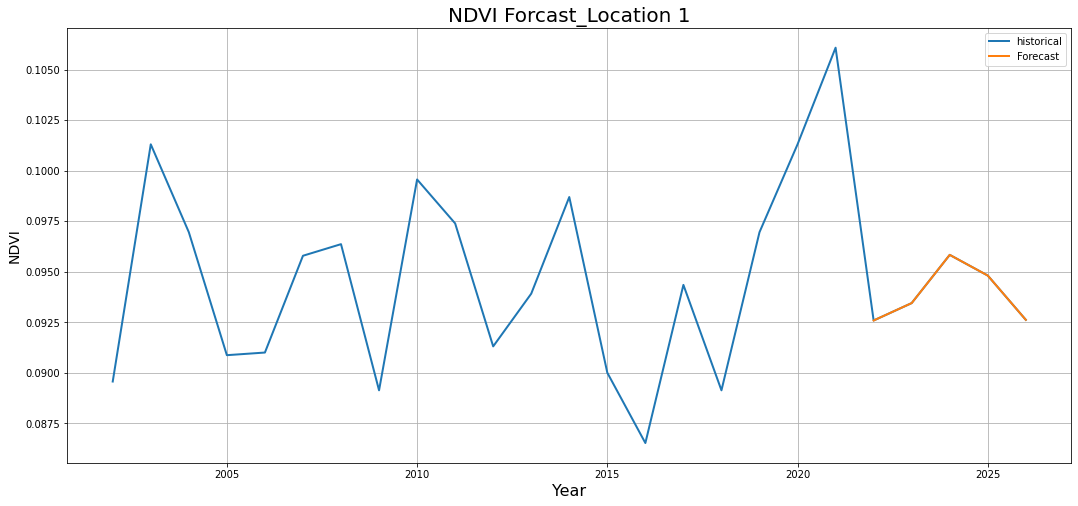

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(L1_NDVI['year'], L1_NDVI['NDVI'],lw=2, label='Historical')
ax.plot(df['year'], df['NDVI'],lw=2, label="Forecast ")
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('NDVI',fontsize=14)
ax.set_title("NDVI Forcast_Location 1",fontsize=20)
ax.grid()
ax.legend();


In [20]:
L2_arr=L2_2022_2026.reshape(-1,1)
L2_arr_new=np.concatenate((year_arr, L2_arr),axis=1)
df2 = pd.DataFrame(L2_arr_new, columns = ['year','NDVI'])
L2_NDVI=year_mean.loc[year_mean['loc'] == 'L2']
L2_NDVI=pd.concat([L2_NDVI, df2], ignore_index=True)
L2_NDVI.loc[:,'year']=L2_NDVI.loc[:,'year'].astype(int)
L2_NDVI

year  loc      NDVI  location
0   2002   L2  0.036522       2.0
1   2003   L2  0.039130       2.0
2   2004   L2  0.052174       2.0
3   2005   L2  0.047391       2.0
4   2006   L2  0.046522       2.0
5   2007   L2  0.044783       2.0
6   2008   L2  0.048696       2.0
7   2009   L2  0.044348       2.0
8   2010   L2  0.048696       2.0
9   2011   L2  0.050435       2.0
10  2012   L2  0.048261       2.0
11  2013   L2  0.055652       2.0
12  2014   L2  0.063913       2.0
13  2015   L2  0.055217       2.0
14  2016   L2  0.053913       2.0
15  2017   L2  0.054348       2.0
16  2018   L2  0.059130       2.0
17  2019   L2  0.064783       2.0
18  2020   L2  0.059130       2.0
19  2021   L2  0.069130       2.0
20  2022  NaN  0.054200       NaN
21  2023  NaN  0.055568       NaN
22  2024  NaN  0.055113       NaN
23  2025  NaN  0.057125       NaN
24  2026  NaN  0.055996       NaN

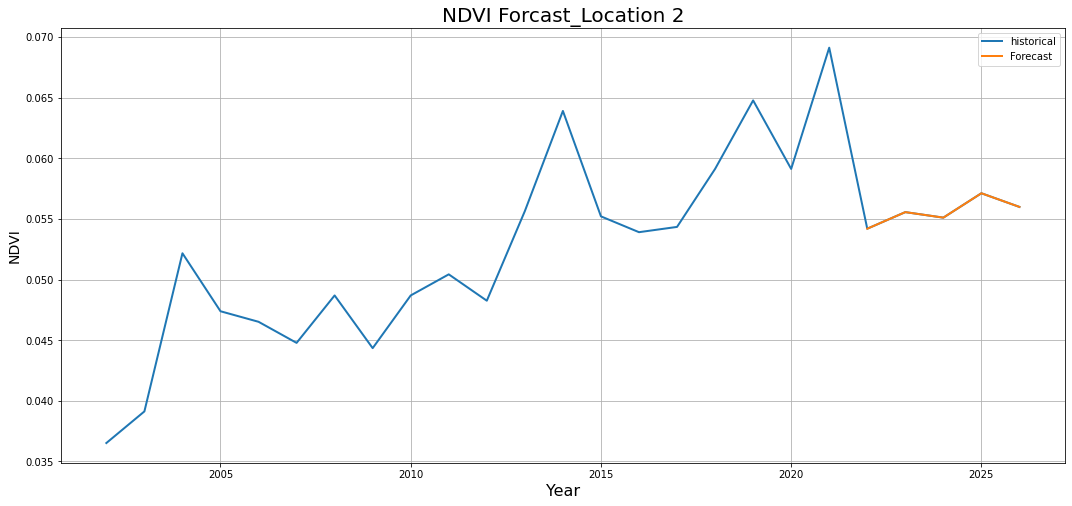

In [88]:
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(L2_NDVI['year'], L2_NDVI['NDVI'],lw=2, label='Historical')
ax.plot(df2['year'], df2['NDVI'],lw=2, label="Forecast ")
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('NDVI',fontsize=14)
ax.set_title("NDVI Forcast_Location 2",fontsize=20)
ax.grid()
ax.legend();


# reference to codes at:

https://github.com/ledmaster/english_tutorials/blob/main/multiple_time_series/workshop_notebook.ipynb
